In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu
from sklearn.metrics import (
   confusion_matrix, ConfusionMatrixDisplay,
   roc_curve, auc,
   precision_recall_curve, average_precision_score
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [19]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

df = pd.read_csv(file_path, parse_dates=['Time'])

df = df.drop(columns=["Unnamed: 0"], errors='ignore')

In [20]:
lst_input = ["VPIN", "Roll", "RollImpact", "AmihudLambda", "CDF"]

list_output = ["SpreadChangeSign", "RealizedVolatilitySign", "JB_ChangeSign", "AR_ChangeSign", "SkewnessSign", "KurtosisSign", "ReturnsSign", "MASign"]
# List các biến mục tiêu
target_cols = list_output

# Khảo sát bộ data

In [21]:
# Chỉ giữ lại các cột cần dùng
df = df[lst_input + list_output]

In [22]:
df.shape

(1877, 13)

- Bộ dữ liệu có những dòng dữ liệu null do quá trình tính toán bằng rolling

In [23]:
# Xóa những dòng có giá trị null
df = df.dropna()
df.shape

(1777, 13)

# PHÂN TÍCH BIẾN ĐẦU VÀO

### Thống kê mô tả của các biến đầu vào cho mô hình

In [24]:
pd.DataFrame(df[lst_input].describe()).T

,count,mean,std,min,25%,50%,75%,max
VPIN,1777.0,1.849840e-01,2.348203e-02,1.268446e-01,1.683314e-01,1.848288e-01,2.009310e-01,2.619265e-01
Roll,1777.0,1.832889e+02,9.973045e+01,7.356593e+00,1.290432e+02,1.783495e+02,2.205043e+02,1.035539e+03
RollImpact,1777.0,5.773110e-06,3.319744e-06,2.358948e-07,4.072190e-06,5.647531e-06,6.928645e-06,3.513454e-05
AmihudLambda,1777.0,9.759078e+06,1.719967e+06,1.951677e+06,8.828917e+06,9.827432e+06,1.072136e+07,1.407243e+07
CDF,1777.0,5.004492e-01,2.922703e-01,5.470460e-04,2.439825e-01,5.021882e-01,7.571116e-01,1.000000e+00


# Kiểm định

### Kiểm tra phân phối của dữ liệu của các biến đầu vào

- Giả thuyết H0: Dữ liệu từng biến đầu vào tuân theo phân phối chuẩn
- Giả thuyết H1: Dữ liệu từng biến đầu không tuân theo phân phối chuẩn.

In [25]:
pvalue_normal_df = pd.DataFrame(index=lst_input, columns=["pvalue"])
for col in lst_input:
    stat, p = shapiro(df[col].dropna())
    # print(f'Shapiro-Wilk test: p-value = {p}')
    pvalue_normal_df.loc[col, "pvalue"] = p
pvalue_normal_df

,pvalue
VPIN,0.0
Roll,0.0
RollImpact,0.0
AmihudLambda,0.0
CDF,0.0


Với mức ý nghĩa 5%:
- p rất bé => Bác bỏ giả thuyết H0. Chưa đủ bằng chứng để kết luận rằng dữ liệu của từng biến đầu vào có phân phối chuẩn

### Kiểm tra phân phối của các cột đầu vào theo từng nhóm

- Giả thuyết H0: Dữ liệu từng biến đầu vào cho từng nhóm có phân phối chuẩn
- Giả thuyế H1: Dữ liệu từng biến đầu cho từng nhóm không có phân phối chuẩn

In [26]:

pvalue_normal_1 = pd.DataFrame(index=target_cols, columns=lst_input)
pvalue_normal_minus1 = pd.DataFrame(index=target_cols, columns=lst_input)

for col in target_cols:
    for col_in in lst_input:
        # print(f"Kiểm định cho giá trị {col} - {col_in}")
        gr1 = df.loc[df[col] == 1, col_in]
        p1 = shapiro(gr1)[1]
        gr2 = df.loc[df[col] == -1, col_in]
        p2 = shapiro(gr1)[1]
        # print(f"pvalue với {col} = 1 cho {col_in}: ", p1)
        # print(f"pvalue với {col} = -1 cho {col_in}: ", p2)
        
        pvalue_normal_1.loc[col, col_in] = p1
        pvalue_normal_minus1.loc[col, col_in] = p2
pvalue_normal_1, pvalue_normal_minus1



(                            VPIN Roll RollImpact AmihudLambda  CDF
 SpreadChangeSign        0.000044  0.0        0.0          0.0  0.0
 RealizedVolatilitySign  0.000096  0.0        0.0          0.0  0.0
 JB_ChangeSign                0.0  0.0        0.0          0.0  0.0
 AR_ChangeSign           0.000002  0.0        0.0          0.0  0.0
 SkewnessSign                 0.0  0.0        0.0          0.0  0.0
 KurtosisSign            0.000163  0.0        0.0          0.0  0.0
 ReturnsSign             0.000076  0.0        0.0          0.0  0.0
 MASign                       0.0  0.0        0.0          0.0  0.0,
                             VPIN Roll RollImpact AmihudLambda  CDF
 SpreadChangeSign        0.000044  0.0        0.0          0.0  0.0
 RealizedVolatilitySign  0.000096  0.0        0.0          0.0  0.0
 JB_ChangeSign                0.0  0.0        0.0          0.0  0.0
 AR_ChangeSign           0.000002  0.0        0.0          0.0  0.0
 SkewnessSign                 0.0  0.0        0

- Bác bỏ giả thuyết H0 rằng data cho từng nhóm có phân phối chuẩn

- Dữ liệu của các cột input và dữ liệu của chúng theo từng nhóm đều không có phân phối chuẩn, ta dùng kiểm định mannwhitneyu để kiểm định xem  giá trị input có khác biệt giữa các nhóm phân loại hay không

### Kiểm định Mannwhitney U
- Giả thuyết không (H₀): Phân phối của hai nhóm là giống nhau (không có sự khác biệt về vị trí trung tâm).

- Giả thuyết đối (H₁): Phân phối của hai nhóm là khác nhau (có sự khác biệt về vị trí trung tâm).

In [27]:
pvalue_df = pd.DataFrame(index=target_cols, columns=lst_input)
for col in target_cols:
    for col_in in lst_input:
        gr1 = df.loc[df[col] == 1, col_in]
        gr2 = df.loc[df[col] == -1, col_in]
        stat, p = mannwhitneyu(gr1, gr2)
        pvalue_df.loc[col, col_in] = p
pvalue_df

,VPIN,Roll,RollImpact,AmihudLambda,CDF
SpreadChangeSign,0.327327,0.434589,0.414796,0.844411,0.327327
RealizedVolatilitySign,0.664911,0.0,0.0,0.0,0.664911
JB_ChangeSign,0.0,0.000243,0.000277,0.449381,0.0
AR_ChangeSign,0.000007,0.0,0.0,0.0,0.000007
SkewnessSign,0.0,0.0,0.0,0.0,0.0
KurtosisSign,0.000001,0.000703,0.000875,0.605394,0.000001
ReturnsSign,0.21396,0.756504,0.839494,0.701973,0.21396
MASign,0.0,0.000013,0.0,0.0,0.0


- VPIN: phân biệt rõ các biến liên quan JB_ChangeSign và KurtosisSign.
- Roll & RollImpact: dự đoán tốt RealizedVolatilitySign, AR_ChangeSign, SkewnessSign, MASign.
- KyleLambda & AmihudLambda: nhạy với RealizedVolatilitySign, AR_ChangeSign, SkewnessSign.
#### Kết luận:
- Roll, RollImpact, Kyle, Amihud là predictors mạnh cho nhiều biến Sign khác nhau.
- VPIN lại đặc biệt nhạy với các biến mô tả phân phối (JB, Kurtosis).
- ReturnsSign và SpreadChangeSign gần như không được phân biệt bởi các metric này.

## Áp dụng model: RandomForest

### Chuẩn bị bộ dữ liệu

- Bộ dữ liệu có sự phân bố nhãn khá cân bằng giữa hai chiều giá trị (-1.0 và 1.0) ở các biến mục tiê. Mỗi biến đều có số lượng mẫu gần như tương đương giữa hai nhãn, với chênh lệch không đáng kể (dao động trong khoảng 2–14 mẫu). Điều này cho thấy bộ dữ liệu phù hợp để huấn luyện các mô hình học máy mà không cần xử lý mất cân bằng nhãn quá phức tạp.

In [28]:
train_data, test_data = {}, {}
for col in target_cols:
    data = df.copy()
    train_data[col], test_data[col] = train_test_split(data, test_size=0.3, random_state=42, stratify=data[col])
    

## Chỉ dùng VPIN làm biến đầu vào

In [29]:
train_cols = ["VPIN", "CDF"]
acc_df = pd.DataFrame(index=target_cols, columns=["Accuracy"])
model_info = {}
for col in list_output:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    acc_df.loc[col, "Accuracy"] = f"{accuracy:.4f}"
acc_df

Độ chính xác của mô hình cho SpreadChangeSign: 0.4906
              precision    recall  f1-score   support

        -1.0       0.49      0.48      0.48       268
         1.0       0.49      0.50      0.50       266

    accuracy                           0.49       534
   macro avg       0.49      0.49      0.49       534
weighted avg       0.49      0.49      0.49       534

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.5375
              precision    recall  f1-score   support

        -1.0       0.54      0.51      0.53       267
         1.0       0.54      0.56      0.55       267

    accuracy                           0.54       534
   macro avg       0.54      0.54      0.54       534
weighted avg       0.54      0.54      0.54       534

Độ chính xác của mô hình cho JB_ChangeSign: 0.5655
              precision    recall  f1-score   support

        -1.0       0.57      0.60      0.58       272
         1.0       0.56      0.53      0.55       262

    accuracy     

,Accuracy
SpreadChangeSign,0.4906
RealizedVolatilitySign,0.5375
JB_ChangeSign,0.5655
AR_ChangeSign,0.4757
SkewnessSign,0.5243
KurtosisSign,0.5375
ReturnsSign,0.4682
MASign,0.5037


## Dùng tất cả các biến input

In [30]:
train_cols =  ['VPIN', 'Roll', 'RollImpact', 'AmihudLambda', 'CDF']

In [31]:


for col in list_output:
    model_info[col] = {}

    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    model_info[col]["y_test"] = test_data[col][col]

    # ---- Pipeline gồm chuẩn hoá + mô hình ----
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                 # hoặc MinMaxScaler()
        ('model', RandomForestClassifier(
            n_estimators=1000, random_state=42
        ))
    ])

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    model_info[col]["model"] = pipeline
    model_info[col]["y_pred"] = pipeline.predict(X_test)
    model_info[col]["y_prob"] = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(model_info[col]["y_test"], model_info[col]["y_pred"])

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(model_info[col]["y_test"], model_info[col]["y_pred"]))

    acc_df.loc[col, "Accuracy"] = f"{accuracy:.4f}"

print("Accuracy df:")
acc_df


Độ chính xác của mô hình cho SpreadChangeSign: 0.4963
              precision    recall  f1-score   support

        -1.0       0.50      0.49      0.50       268
         1.0       0.49      0.50      0.50       266

    accuracy                           0.50       534
   macro avg       0.50      0.50      0.50       534
weighted avg       0.50      0.50      0.50       534

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.8745
              precision    recall  f1-score   support

        -1.0       0.89      0.85      0.87       267
         1.0       0.86      0.90      0.88       267

    accuracy                           0.87       534
   macro avg       0.88      0.87      0.87       534
weighted avg       0.88      0.87      0.87       534

Độ chính xác của mô hình cho JB_ChangeSign: 0.7715
              precision    recall  f1-score   support

        -1.0       0.78      0.77      0.77       272
         1.0       0.76      0.77      0.77       262

    accuracy     

,Accuracy
SpreadChangeSign,0.4963
RealizedVolatilitySign,0.8745
JB_ChangeSign,0.7715
AR_ChangeSign,0.8184
SkewnessSign,0.8146
KurtosisSign,0.7753
ReturnsSign,0.5169
MASign,0.8408


In [32]:
# # train_cols = lst_input
# acc_df = pd.DataFrame(index=target_cols, columns=["Accuracy"])
# model_info = {}
# for col in list_output:
#     model_info[col] = {}
#     X_train = train_data[col][train_cols]
#     y_train = train_data[col][col]
#     X_test = test_data[col][train_cols]
#     model_info[col]["y_test"] = test_data[col][col]

#     model_info[col]["model"] = RandomForestClassifier(n_estimators=1000, random_state=42)

#     model_info[col]["model"].fit(X_train, y_train)

#     model_info[col]["y_pred"] = model_info[col]["model"].predict(X_test)
#     model_info[col]["y_prob"] = model_info[col]["model"].predict_proba(X_test)[:, 1]
#     accuracy = accuracy_score(model_info[col]["y_test"], model_info[col]["y_pred"])
#     report = classification_report(model_info[col]["y_test"], model_info[col]["y_pred"], output_dict=True)

#     print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
#     print(classification_report(model_info[col]["y_test"], model_info[col]["y_pred"]))
#     acc_df.loc[col, "Accuracy"] = f"{accuracy:.4f}"
# print("Accuracy df:")
# acc_df

SpreadChangeSign


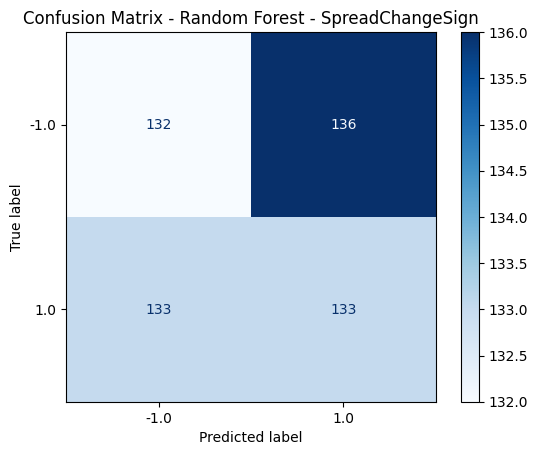

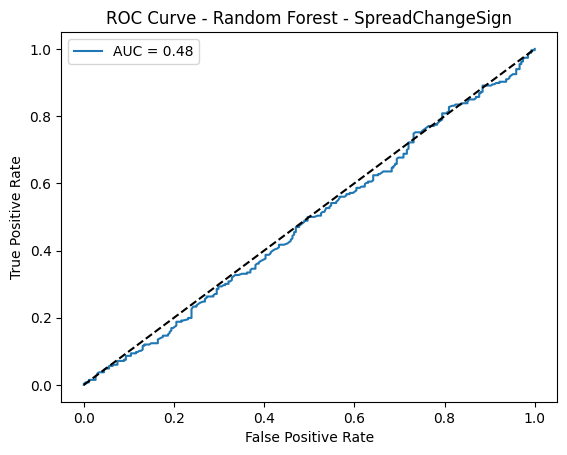

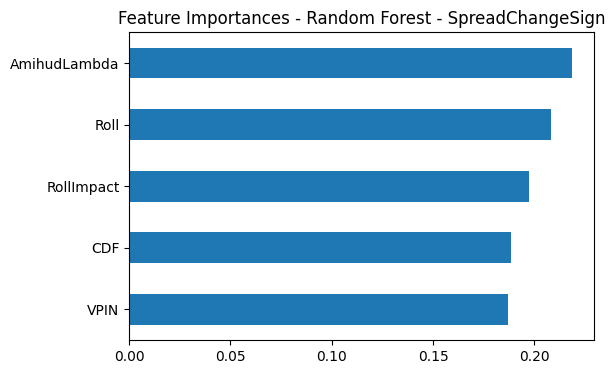

RealizedVolatilitySign


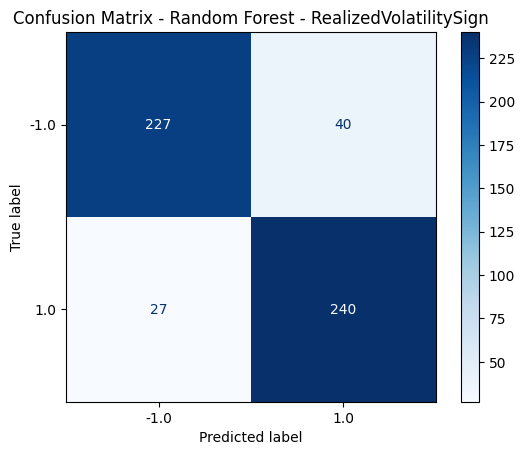

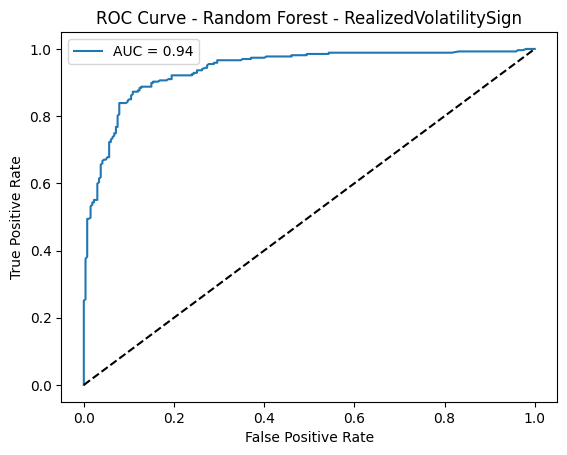

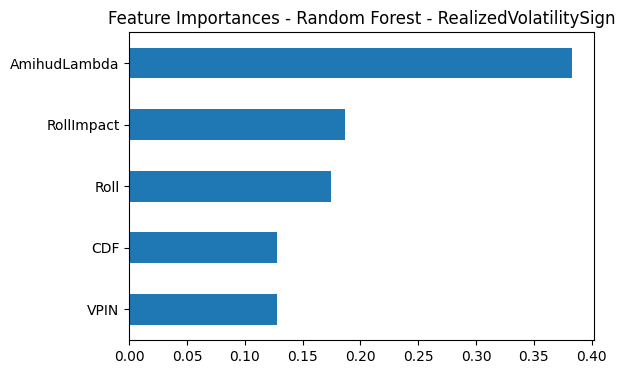

JB_ChangeSign


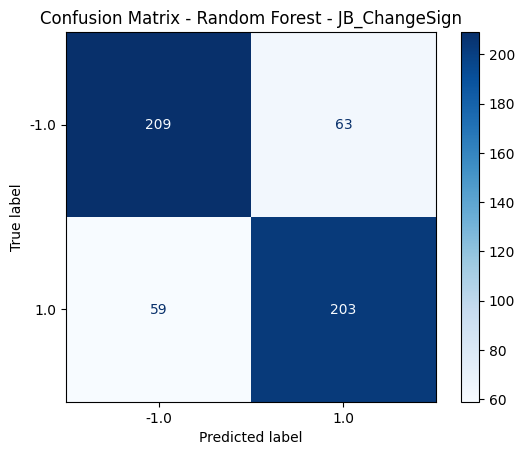

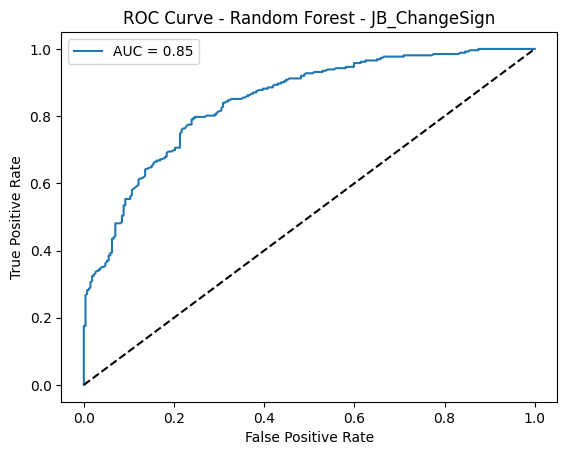

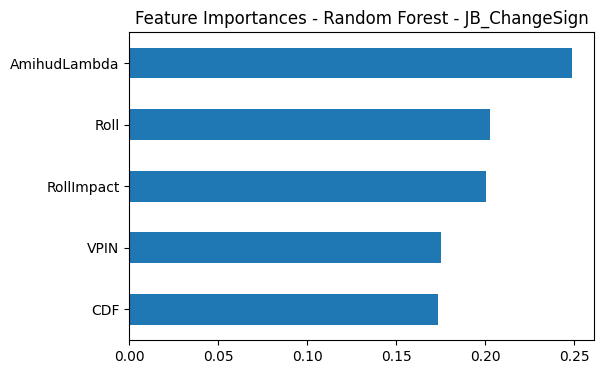

AR_ChangeSign


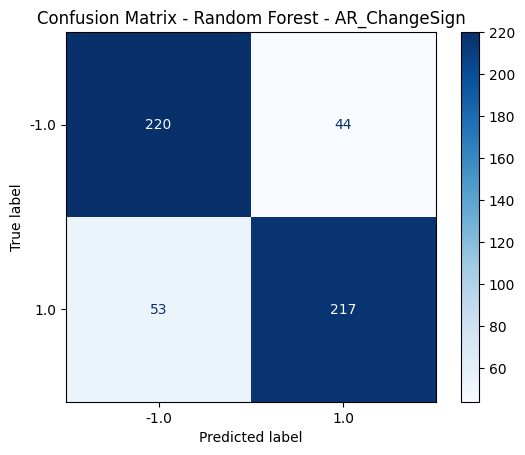

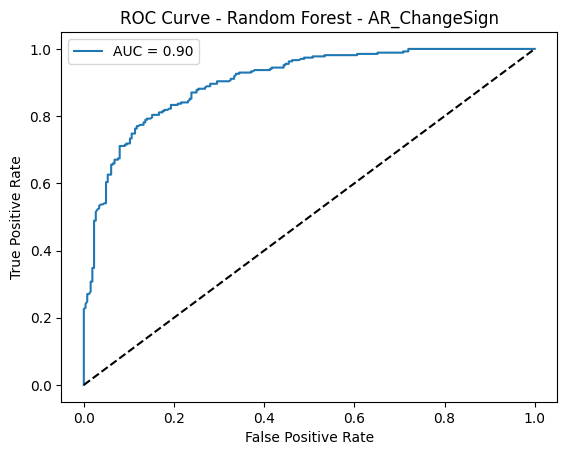

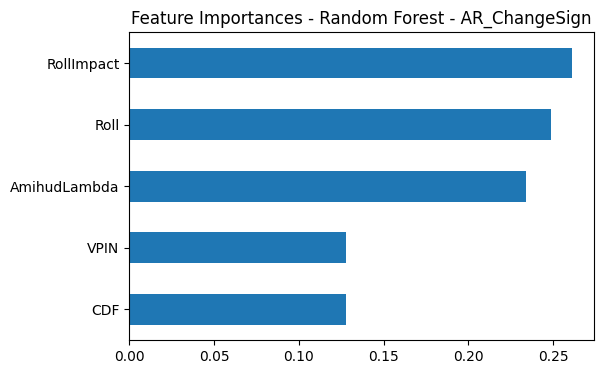

SkewnessSign


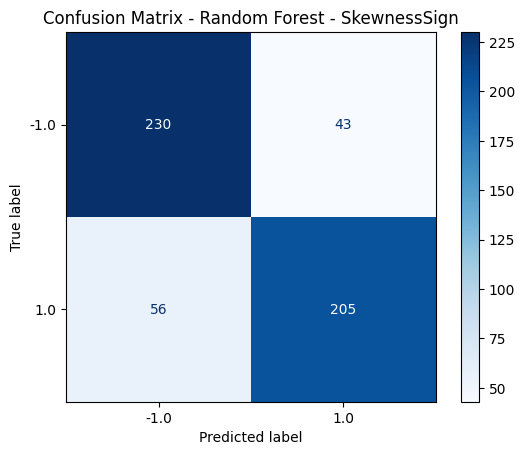

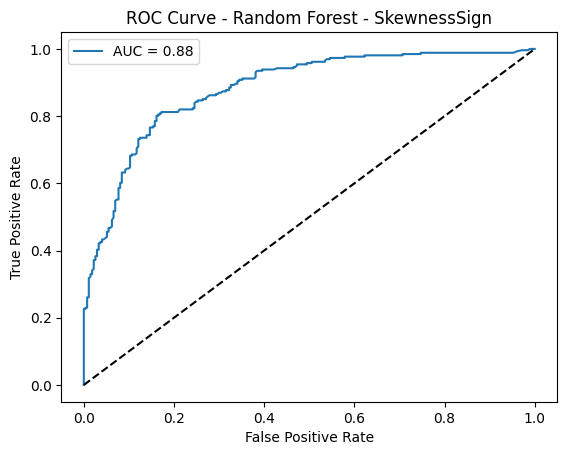

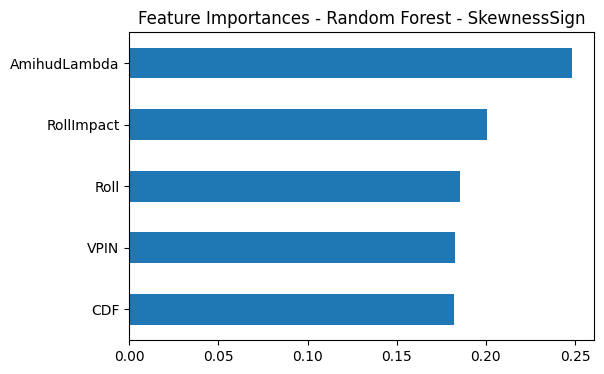

KurtosisSign


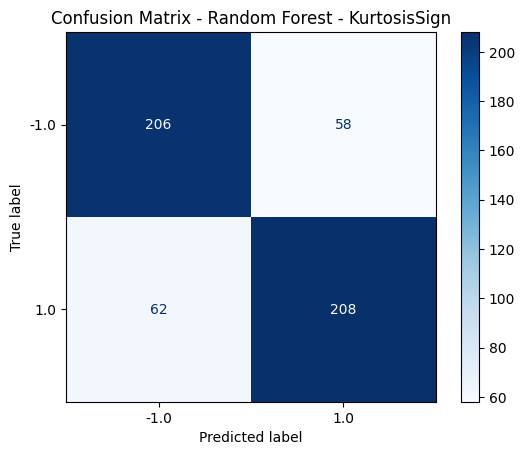

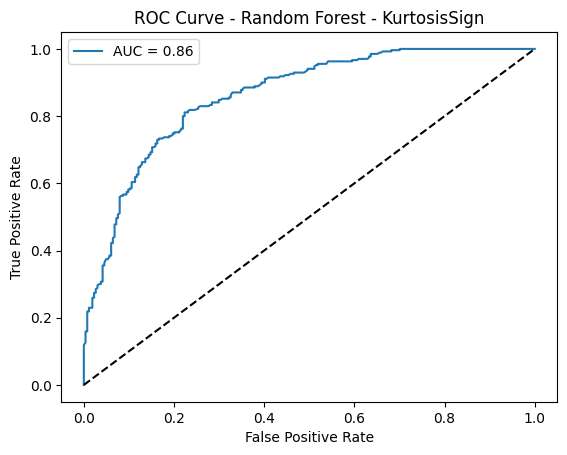

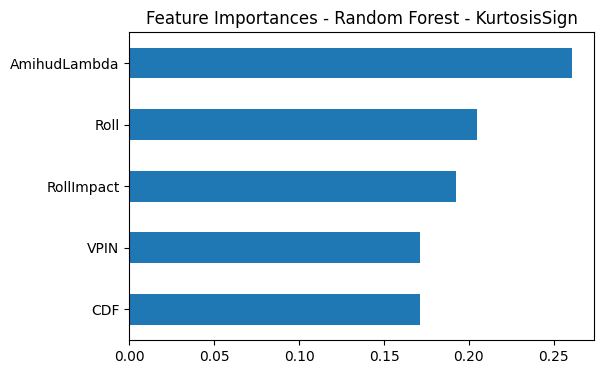

ReturnsSign


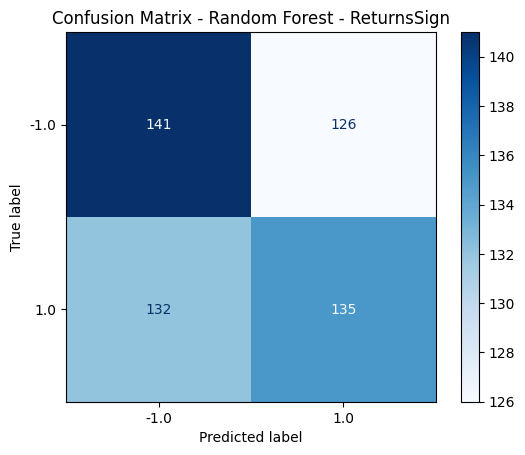

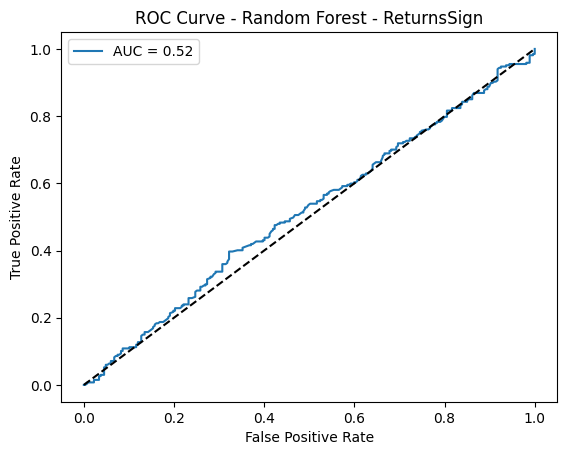

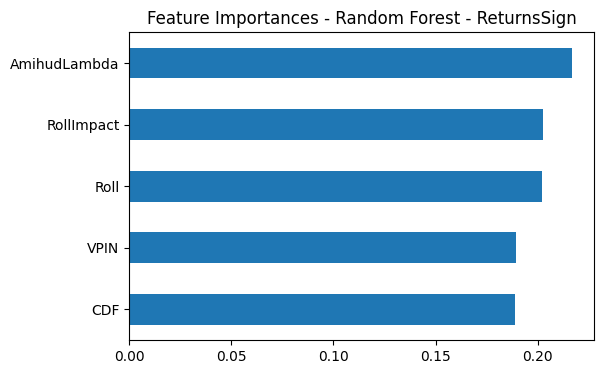

MASign


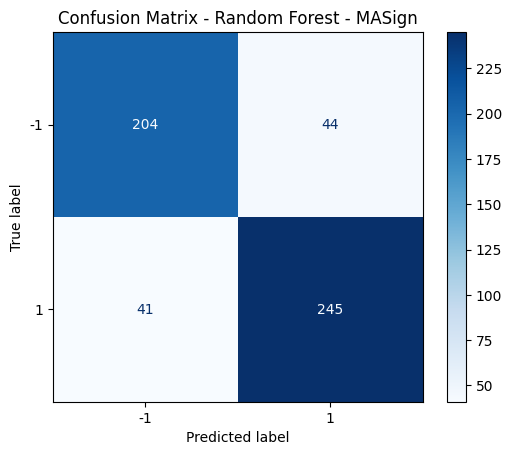

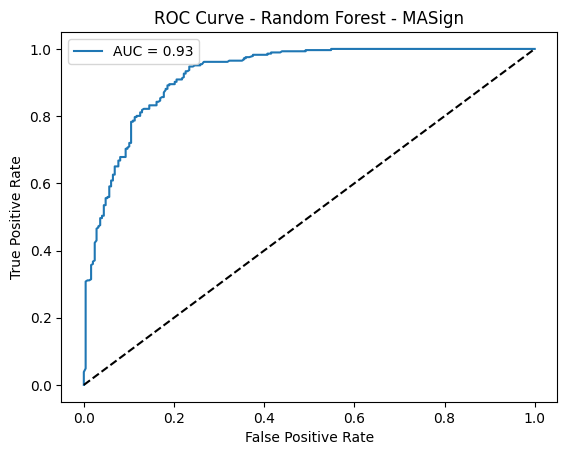

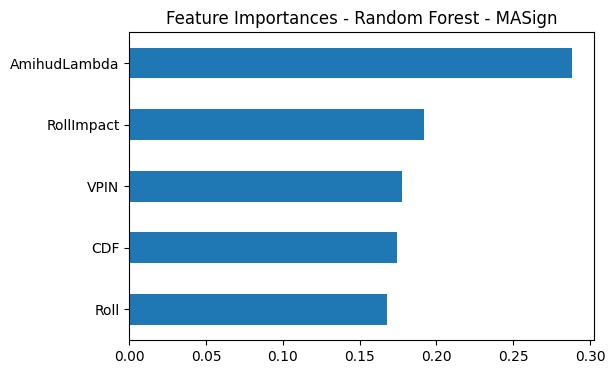

In [33]:
for col in target_cols:
    print(col)
    data_info = model_info[col]
    cm = confusion_matrix(data_info["y_test"], data_info["y_pred"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_info["model"].classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Random Forest - {col}")
    plt.show()
    #########
    fpr, tpr, thresholds = roc_curve(data_info["y_test"], data_info["y_prob"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Random Forest - {col}")
    plt.legend()
    plt.show()
    # importances =  data_info["model"].feature_importances_
    importances = model_info[col]["model"]["model"].feature_importances_
    feat_importances = pd.Series(importances, index=X_train.columns)
    feat_importances.sort_values().plot(kind="barh", figsize=(6,4))
    plt.title(f"Feature Importances - Random Forest - {col}")
    plt.show()

In [34]:
acc_df = pd.DataFrame(index=target_cols, columns=train_cols)
model_info = {}
for col in list_output:
    for col_in in lst_input:
        train_cols = [col_in]
        X_train = train_data[col][train_cols]
        y_train = train_data[col][col]
        X_test = test_data[col][train_cols]
        y_test = test_data[col][col]

        model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

        model_info[col].fit(X_train, y_train)

        y_pred = model_info[col].predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        acc_df.loc[col, col_in] = f"{accuracy:.4f}"
acc_df

Độ chính xác của mô hình cho SpreadChangeSign: 0.4888
              precision    recall  f1-score   support

        -1.0       0.49      0.48      0.49       268
         1.0       0.49      0.50      0.49       266

    accuracy                           0.49       534
   macro avg       0.49      0.49      0.49       534
weighted avg       0.49      0.49      0.49       534

Độ chính xác của mô hình cho SpreadChangeSign: 0.5206
              precision    recall  f1-score   support

        -1.0       0.52      0.54      0.53       268
         1.0       0.52      0.50      0.51       266

    accuracy                           0.52       534
   macro avg       0.52      0.52      0.52       534
weighted avg       0.52      0.52      0.52       534

Độ chính xác của mô hình cho SpreadChangeSign: 0.4813
              precision    recall  f1-score   support

        -1.0       0.48      0.46      0.47       268
         1.0       0.48      0.50      0.49       266

    accuracy        

,VPIN,Roll,RollImpact,AmihudLambda,CDF
SpreadChangeSign,0.4888,0.5206,0.4813,0.4775,0.5094
RealizedVolatilitySign,0.5599,0.5524,0.5693,0.6142,0.5375
JB_ChangeSign,0.5562,0.5094,0.5712,0.5187,0.5506
AR_ChangeSign,0.4757,0.5993,0.6199,0.5581,0.4906
SkewnessSign,0.5281,0.5655,0.5712,0.5468,0.5262
KurtosisSign,0.5206,0.5281,0.5318,0.5318,0.5206
ReturnsSign,0.4625,0.5243,0.5300,0.5094,0.4588
MASign,0.5075,0.5562,0.5805,0.5824,0.5056
